In [2]:
# importing libaries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import os
import glob
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.neighbors import NearestNeighbors
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import warnings
warnings.filterwarnings('ignore')


In [3]:
# Define file names and corresponding variable names
files = {
    "countryIndi": "Country_Indicators.csv",
    "country": "Country.csv",
    "economicIndi": "Economic_Indicators.csv",
    "enviroIndi": "Environmental_Indicators.csv",
    "qpsdIndi": "Public_Debt_Indicators_Agg.csv",
    "socialIndi": "Social_Indicators.csv",
    "statIndi": "Statistical_Indicators.csv",
    "yearIndi": "Year_Table.csv"
}

# Base path
base_path = '../WEEK 3/Indicators/'

# Read all files into a dictionary of DataFrames
data = {key: pd.read_csv(base_path + filename) for key, filename in files.items()}


In [4]:
data.keys()

dict_keys(['countryIndi', 'country', 'economicIndi', 'enviroIndi', 'qpsdIndi', 'socialIndi', 'statIndi', 'yearIndi'])

In [5]:
data['country'].head(3)

,Country Name,Country Code,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,Afghanistan,AFG,NaN,NaN,NaN
1,Albania,ALB,NaN,NaN,NaN
2,Algeria,DZA,NaN,NaN,NaN


In [6]:
# Fetch column shape from each DataFrame in the dictionary
for name, df in data.items():
    print(f"\nShape of '{name}': {df.shape[0]} rows, {df.shape[1]} columns")

data['country'].drop(columns=['Unnamed: 2', 'Unnamed: 3'], inplace=True)


Shape of 'countryIndi': 809 rows, 10 columns

Shape of 'country': 810 rows, 5 columns

Shape of 'economicIndi': 803 rows, 68 columns

Shape of 'enviroIndi': 803 rows, 11 columns

Shape of 'qpsdIndi': 318 rows, 67 columns

Shape of 'socialIndi': 803 rows, 75 columns

Shape of 'statIndi': 798 rows, 13 columns

Shape of 'yearIndi': 3 rows, 2 columns


In [7]:
import pandas as pd

# Step 1: Convert merge keys to the same type
for df_name in ['countryIndi', 'economicIndi', 'enviroIndi', 'qpsdIndi', 'socialIndi', 'statIndi', 'yearIndi']:
    for col in ['Country Code', 'Time', 'Time Code']:
        if col in data[df_name].columns:
            data[df_name][col] = data[df_name][col].astype(str)

# Step 2: Start merging one by one
merged_df = data['countryIndi']

# Define list of other datasets to merge (excluding 'countryIndi' which is already used)
to_merge = ['economicIndi', 'enviroIndi', 'qpsdIndi', 'socialIndi', 'statIndi']

# Step 3: Merge all indicator datasets on 'Country Code' and 'Time'
for key in to_merge:
    merged_df = pd.merge(merged_df, data[key], on=['Country Code', 'Time'], how='outer', suffixes=('', f'_{key}'))

# Step 4: Merge the year table (to bring in Time Code if needed)
if 'Time Code' not in merged_df.columns:
    merged_df = pd.merge(merged_df, data['yearIndi'], on='Time', how='left')

# Optional: Merge country table to enrich with names if needed
#merged_df = pd.merge(merged_df, data['country'], on='Country Code', how='left', suffixes=('', '_country'))

# Step 5: Drop duplicate columns if any (like multiple 'Country Name' columns)
merged_df = merged_df.loc[:, ~merged_df.columns.duplicated()]


In [8]:
merged_df.head(5)

,Country Name,Country Code,Time,Time Code,Adjusted net national income (annual % growth) [NY.ADJ.NNTY.KD.ZG],Adjusted net national income (constant 2015 US$) [NY.ADJ.NNTY.KD],Adjusted net national income (current US$) [NY.ADJ.NNTY.CD],Adjusted net national income per capita (annual % growth) [NY.ADJ.NNTY.PC.KD.ZG],Adjusted net national income per capita (constant 2015 US$) [NY.ADJ.NNTY.PC.KD],Adjusted net national income per capita (current US$) [NY.ADJ.NNTY.PC.CD],...,Time Code_statIndi,Broad_Money_Perc,Broad_Money_Total,Broad_Money_Growth,Broad_Money_Reserves,Exchange_Rate,Total_Reserves_Perc,Total_Reserves_Gold,Total_Reserves_Months_Imports,Total_Reserves_Without_Gold
0,NaN,ABW,2021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,YR2021,102.3226044,5365500000,11.84183099,1.981206032,1.79,..,1512960280,8.608908926,1330950280
1,Aruba,ABW,2021.0,YR2021,..,..,2662868130,..,..,24724.86657,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,ABW,2022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,YR2022,94.44252884,5543800000,3.323082658,2.005967712,1.79,..,1543940590,6.978284418,1362705590
3,Aruba,ABW,2022.0,YR2022,..,..,..,..,..,..,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,ABW,2023,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,YR2023,85.55422252,5587500000,0.788267975,2.126148351,1.79,..,1468151730,..,1261911730


In [9]:
merged_df.shape

(2971, 234)

In [10]:
merged_df.isnull().sum()

Country Name                                                          2173
Country Code                                                             0
Time                                                                     0
Time Code                                                              798
Adjusted net national income (annual % growth) [NY.ADJ.NNTY.KD.ZG]    2173
                                                                      ... 
Exchange_Rate                                                         2173
Total_Reserves_Perc                                                   2173
Total_Reserves_Gold                                                   2173
Total_Reserves_Months_Imports                                         2173
Total_Reserves_Without_Gold                                           2173
Length: 234, dtype: int64

In [11]:
print("Number of rows with null Country Name:", merged_df['Country Name'].isna().sum())
null_countries = merged_df[merged_df['Country Name'].isna()]
null_countries

# lets drop such rows 
merged_df = merged_df[merged_df['Country Name'].notna()].reset_index(drop=True)
merged_df.shape

Number of rows with null Country Name: 2173


(798, 234)

In [12]:
merged_df.isnull().sum()

Country Name                                                            0
Country Code                                                            0
Time                                                                    0
Time Code                                                               0
Adjusted net national income (annual % growth) [NY.ADJ.NNTY.KD.ZG]      0
                                                                     ... 
Exchange_Rate                                                         798
Total_Reserves_Perc                                                   798
Total_Reserves_Gold                                                   798
Total_Reserves_Months_Imports                                         798
Total_Reserves_Without_Gold                                           798
Length: 234, dtype: int64

In [13]:
# Identify categorical columns to exclude
exclude_cols = ['Country Name', 'Country Code']  # Add more as needed

# Convert remaining columns to float safely
for col in merged_df.columns:
    if col not in exclude_cols:
        merged_df[col] = pd.to_numeric(merged_df[col], errors='coerce')

In [14]:
merged_df.isnull().sum()
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 798 entries, 0 to 797
Columns: 234 entries, Country Name to Total_Reserves_Without_Gold
dtypes: float64(232), object(2)
memory usage: 1.4+ MB


Dropping columns having more then 50% of data missing 

In [15]:
# Calculate missing percentage for each column
missing_percent = merged_df.isna().mean()

# Identify columns to drop
cols_to_drop = missing_percent[missing_percent > 0.5].index.tolist()

# Print them
print(f"Columns with >50% missing values ({len(cols_to_drop)}):\n")
#for col in cols_to_drop:
    #print("-", col)

Columns with >50% missing values (166):



In [16]:
# Column to protect
protected_col = 'Renewable energy consumption (% of total final energy consumption) [EG.FEC.RNEW.ZS]'

# Refine list of columns to drop (excluding the protected one)
cols_to_drop = [col for col in cols_to_drop if col != protected_col]

# Now drop safely
merged_df = merged_df.drop(columns=cols_to_drop)


In [17]:
merged_df['Time'] = pd.to_numeric(merged_df['Time'], errors='coerce').astype('Int64')

In [18]:
import numpy as np
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Step 1: Select numeric columns
numeric_df = merged_df.select_dtypes(include=[np.number])

# Step 2: Drop constant and null-containing columns
numeric_df = numeric_df.dropna()
numeric_df = numeric_df.loc[:, numeric_df.nunique() > 1]

# Step 3: Drop rows with inf or -inf
numeric_df = numeric_df.replace([np.inf, -np.inf], np.nan).dropna()

# Step 4: Convert to float64 explicitly (critical)
numeric_df = numeric_df.astype(np.float64)

# Step 5: Calculate VIF
vif_data = pd.DataFrame()
vif_data['Feature'] = numeric_df.columns
vif_data['VIF'] = [variance_inflation_factor(numeric_df.values, i) for i in range(numeric_df.shape[1])]

# Display
#print(vif_data.sort_values(by='VIF', ascending=False))


In [19]:
# Drop inf VIF Columns

# Step 1: Identify features with infinite VIF
inf_vif_features = vif_data[vif_data['VIF'] == np.inf]['Feature'].tolist()

# Step 2: Drop them from the main DataFrame
merged_df = merged_df.drop(columns=inf_vif_features)

# Step 3: Confirm
print(f"Dropped {len(inf_vif_features)} columns with infinite VIF:")
for col in inf_vif_features:
    print("-", col)


Dropped 8 columns with infinite VIF:
- GDP (current LCU) [NY.GDP.MKTP.CN]
- GDP: linked series (current LCU) [NY.GDP.MKTP.CN.AD]
- Goods exports (BoP, current US$) [BX.GSR.MRCH.CD]
- Goods imports (BoP, current US$) [BM.GSR.MRCH.CD]
- Net trade in goods (BoP, current US$) [BN.GSR.MRCH.CD]
- Net trade in goods and services (BoP, current US$) [BN.GSR.GNFS.CD]
- Service exports (BoP, current US$) [BX.GSR.NFSV.CD]
- Service imports (BoP, current US$) [BM.GSR.NFSV.CD]


In [20]:
# Step 1: Filter out features with VIF greater than 10
high_vif = vif_data[vif_data['VIF'] > 10]

# Step 2: Display the results
print(f"Number of features with VIF > 10: {high_vif.shape[0]}")
print("Features with high multicollinearity (VIF > 10):")
#high_vif[['Feature', 'VIF']].sort_values(by='VIF', ascending=False)

Number of features with VIF > 10: 60
Features with high multicollinearity (VIF > 10):


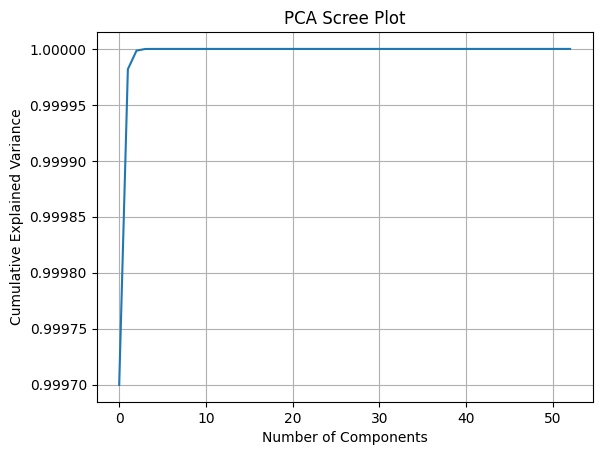

In [21]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA().fit(merged_df.select_dtypes(include='number').dropna())
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Scree Plot')
plt.grid(True)
plt.show()


Key Observations:
The curve rises steeply in the first few components.
After around 5–6 components, the curve plateaus near 100% cumulative variance.
This means:
Most of the variance (information) in your dataset is captured by just a few components (likely < 10).
What This Means Practically:
Your dataset likely has redundant or highly correlated features.
You can reduce the dimensionality to just the first 5–6 components without losing much information.
This will:Improve model efficiency,Remove noise,Reduce multicollinearity.

So thats why picking only those columns that are highly related to target variable while we perform EDA 

##### Predict: Will rapid economic growth cause environmental degradation?

In [22]:
# Creating new dataframe with only the columns we want to predict
#  Step 1: Define the list of columns you want
columns_needed = [
    'Country Name',
    'Country Code',
    'Time',
    'GDP growth (annual %) [NY.GDP.MKTP.KD.ZG]',
    'GDP per capita growth (annual %) [NY.GDP.PCAP.KD.ZG]',
    'Foreign direct investment, net inflows (% of GDP) [BX.KLT.DINV.WD.GD.ZS]',
    'Gross domestic savings (% of GDP) [NY.GDS.TOTL.ZS]',
    'Exports of goods and services (% of GDP) [NE.EXP.GNFS.ZS]',
    'Imports of goods and services (% of GDP) [NE.IMP.GNFS.ZS]',
    'General government final consumption expenditure (% of GDP) [NE.CON.GOVT.ZS]',
    'Carbon dioxide (CO2) emissions (total) excluding LULUCF (% change from 1990) [EN.GHG.CO2.ZG.AR5]',
    'Carbon dioxide (CO2) emissions excluding LULUCF per capita (t CO2e/capita) [EN.GHG.CO2.PC.CE.AR5]',
    'Forest area (sq. km) [AG.LND.FRST.K2]',
    'Access to electricity, rural (% of rural population) [EG.ELC.ACCS.RU.ZS]',
    'Access to electricity, urban (% of urban population) [EG.ELC.ACCS.UR.ZS]',
    'Renewable energy consumption (% of total final energy consumption) [EG.FEC.RNEW.ZS]',
]

# Step 2: Create the new DataFrame
df_analysis = merged_df[columns_needed].copy()


In [23]:
df_analysis.shape

(798, 16)

In [24]:
df_analysis.isna().sum()

Country Name                                                                                           0
Country Code                                                                                           0
Time                                                                                                   0
GDP growth (annual %) [NY.GDP.MKTP.KD.ZG]                                                             44
GDP per capita growth (annual %) [NY.GDP.PCAP.KD.ZG]                                                  44
Foreign direct investment, net inflows (% of GDP) [BX.KLT.DINV.WD.GD.ZS]                             112
Gross domestic savings (% of GDP) [NY.GDS.TOTL.ZS]                                                   173
Exports of goods and services (% of GDP) [NE.EXP.GNFS.ZS]                                            150
Imports of goods and services (% of GDP) [NE.IMP.GNFS.ZS]                                            147
General government final consumption expenditure (% of 

In [25]:
df_analysis.head(5)

,Country Name,Country Code,Time,GDP growth (annual %) [NY.GDP.MKTP.KD.ZG],GDP per capita growth (annual %) [NY.GDP.PCAP.KD.ZG],"Foreign direct investment, net inflows (% of GDP) [BX.KLT.DINV.WD.GD.ZS]",Gross domestic savings (% of GDP) [NY.GDS.TOTL.ZS],Exports of goods and services (% of GDP) [NE.EXP.GNFS.ZS],Imports of goods and services (% of GDP) [NE.IMP.GNFS.ZS],General government final consumption expenditure (% of GDP) [NE.CON.GOVT.ZS],Carbon dioxide (CO2) emissions (total) excluding LULUCF (% change from 1990) [EN.GHG.CO2.ZG.AR5],Carbon dioxide (CO2) emissions excluding LULUCF per capita (t CO2e/capita) [EN.GHG.CO2.PC.CE.AR5],Forest area (sq. km) [AG.LND.FRST.K2],"Access to electricity, rural (% of rural population) [EG.ELC.ACCS.RU.ZS]","Access to electricity, urban (% of urban population) [EG.ELC.ACCS.UR.ZS]",Renewable energy consumption (% of total final energy consumption) [EG.FEC.RNEW.ZS]
0,Aruba,ABW,2021,24.132627,25.154964,4.558715,16.252690,70.740043,76.275533,22.831706,149.178696,4.648097,4.200,100.000000,100.000000,8.8
1,Aruba,ABW,2022,8.517918,8.912308,7.567072,23.173911,87.570280,85.313891,21.207764,150.223992,4.684559,4.200,100.000000,100.000000,8.8
2,Aruba,ABW,2023,4.263719,4.216132,2.506331,28.350292,88.343786,81.454497,19.562473,163.812842,4.936708,NaN,NaN,NaN,NaN
3,Africa Eastern and Southern,AFE,2021,4.576393,1.842087,5.012059,20.706606,26.015608,26.290790,14.651255,56.557711,0.863533,4446875.546,32.809138,75.483124,NaN
4,Africa Eastern and Southern,AFE,2022,3.553878,0.903488,1.695914,20.224171,27.631441,29.964385,14.429799,54.384758,0.816361,4414514.929,33.760782,75.847809,NaN


In [26]:
df_analysis['Time'] = pd.to_numeric(df_analysis['Time'], errors='coerce').astype('Int64')

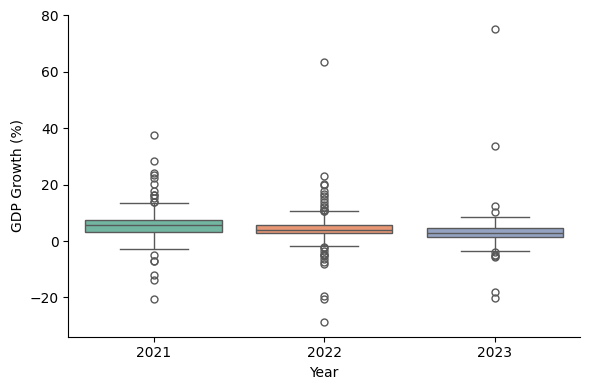

In [27]:
#create the box plot
g=sns.catplot(data= df_analysis, x='Time',
            y='GDP growth (annual %) [NY.GDP.MKTP.KD.ZG]',kind='box', height=4, aspect=1.5, palette='Set2')

# Rename axes directly
g.set_axis_labels("Year", "GDP Growth (%)")


In [28]:
df_grouped = df_analysis.groupby('Time')[
    ['Renewable energy consumption (% of total final energy consumption) [EG.FEC.RNEW.ZS]',
     'Carbon dioxide (CO2) emissions excluding LULUCF per capita (t CO2e/capita) [EN.GHG.CO2.PC.CE.AR5]']
].mean()

df_grouped.corr()


,Renewable energy consumption (% of total final energy consumption) [EG.FEC.RNEW.ZS],Carbon dioxide (CO2) emissions excluding LULUCF per capita (t CO2e/capita) [EN.GHG.CO2.PC.CE.AR5]
Renewable energy consumption (% of total final energy consumption) [EG.FEC.RNEW.ZS],1.0,-1.0
Carbon dioxide (CO2) emissions excluding LULUCF per capita (t CO2e/capita) [EN.GHG.CO2.PC.CE.AR5],-1.0,1.0


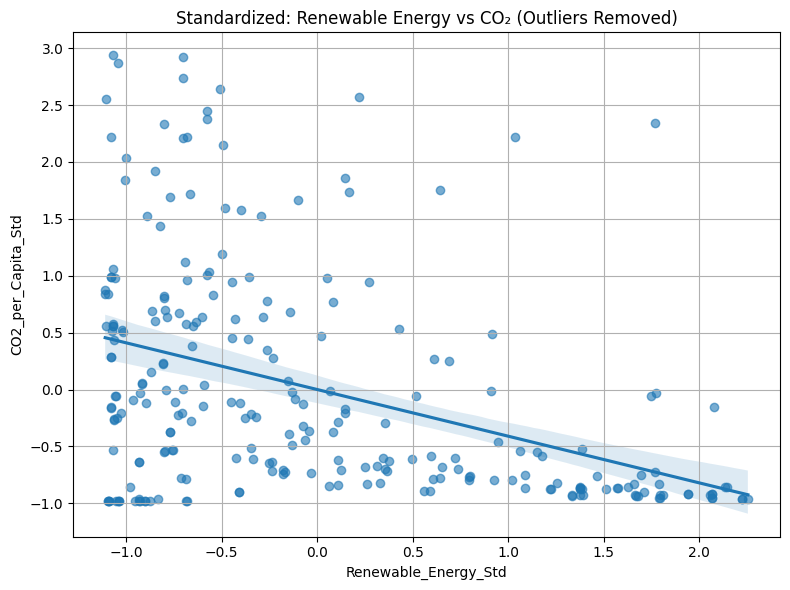

In [29]:
def remove_outliers_iqr(df, columns):
    df_clean = df.copy()
    for col in columns:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df_clean = df_clean[(df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound)]
    return df_clean

# Columns to check
columns = [
    'Renewable energy consumption (% of total final energy consumption) [EG.FEC.RNEW.ZS]', 
    'Carbon dioxide (CO2) emissions excluding LULUCF per capita (t CO2e/capita) [EN.GHG.CO2.PC.CE.AR5]'
]

# Remove outliers
df_no_outliers = remove_outliers_iqr(df_analysis[columns].dropna(), columns)

# Optional: standardize
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_no_outliers)

df_scaled_clean = pd.DataFrame(scaled_data, columns=['Renewable_Energy_Std', 'CO2_per_Capita_Std'])

# Plot again
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
sns.regplot(x='Renewable_Energy_Std', y='CO2_per_Capita_Std', data=df_scaled_clean, scatter_kws={'alpha':0.6})
plt.title('Standardized: Renewable Energy vs CO₂ (Outliers Removed)')
plt.grid(True)
plt.tight_layout()
plt.show()


##### lets create logic for target variable
- GDP Growth (%)	CO₂ Emissions (%)	Label	Meaning
- greater than(>) 3%	> 2%	'High Degradation'	Growth with degradation
- greater than(>) 3%	≤ 0%	'Green Growth'	Growth but with clean energy
- ≤ 3%	> 2%	'Pollution w/o Growth'	Degradation but not growing
- ≤ 3%	≤ 0%	'Stable'	Neither growing nor degrading

In [30]:
# Rename for ease (optional)
df = df_analysis.rename(columns={
    'GDP growth (annual %) [NY.GDP.MKTP.KD.ZG]': 'GDP_growth',
    'Carbon dioxide (CO2) emissions (total) excluding LULUCF (% change from 1990) [EN.GHG.CO2.ZG.AR5]': 'CO2_change'
})

# Define the target variable
def label_degradation(row):
    if row['GDP_growth'] > 3 and row['CO2_change'] > 2:
        return 'High Degradation'
    elif row['GDP_growth'] > 3 and row['CO2_change'] <= 0:
        return 'Green Growth'
    elif row['GDP_growth'] <= 3 and row['CO2_change'] > 2:
        return 'Pollution w/o Growth'
    else:
        return 'Stable'

df['Degradation_Label'] = df.apply(label_degradation, axis=1)


In [31]:
df['Degradation_Label'].value_counts()


Degradation_Label
High Degradation        341
Stable                  218
Pollution w/o Growth    142
Green Growth             97
Name: count, dtype: int64

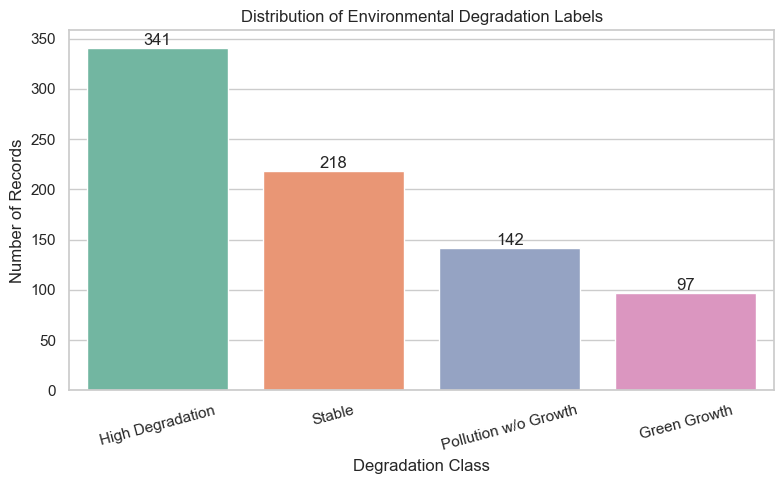

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set style
sns.set(style="whitegrid")

# Plot the count of each degradation class
plt.figure(figsize=(8, 5))
ax = sns.countplot(data=df, x='Degradation_Label', palette='Set2', order=df['Degradation_Label'].value_counts().index)

# Add labels on bars
for container in ax.containers:
    ax.bar_label(container)

plt.title('Distribution of Environmental Degradation Labels')
plt.xlabel('Degradation Class')
plt.ylabel('Number of Records')
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()


You’ll see a bar for each class:
- High Degradation: Likely countries with booming GDP + rising emissions
- Green Growth: Sustainable growth (your desired zone!)
- Pollution w/o Growth: Worst-case scenarios (no growth + rising emissions)
- Stable: Countries with low emissions and low growth

In [33]:
import plotly.express as px
# Prepare the DataFrame for choropleth
# Assuming 'Country Code' already contains ISO-3 codes

fig = px.choropleth(
    df,
    locations="Country Code",  # 3-letter ISO country code
    color="Degradation_Label",
    hover_name="Country Name",  # shows full country name on hover
    animation_frame="Time",     # year-wise slider if multiple years
    color_discrete_map={
        "High Degradation": "red",
        "Green Growth": "green",
        "Stable": "gray",
        "Pollution w/o Growth": "orange"
    },
    title="Environmental Degradation Classification by Degradation Class, by Country and Year",
    labels={"Degradation_Label": "Degradation Class"}
)

fig.update_geos(showcountries=True, showcoastlines=True, showland=True, fitbounds="locations")
fig.update_layout(height=800)
fig.show()


In [34]:
fig.write_image("choropleth_map.png")


Classifying countries into 4 cateogry, can let us predict Environmental outcomes based on growth indicators.

Using XGBoost Model

In [35]:
# developing model
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier, plot_importance
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt


X= df.drop(columns=['Country Name', 'Country Code', 'Time', 'Degradation_Label'])
y= df['Degradation_Label']

# Encode target labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Clean column names by removing problematic characters
X.columns = X.columns.str.replace(r"[\[\]<>]", "", regex=True)

#Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)


# Train the XGBoost Classifier
xg_Model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xg_Model.fit(X_train, y_train)

# Predict
y_pred = xg_Model.predict(X_test)


In [36]:
# Evaluate the model
print(" Accuracy Score:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))

 Accuracy Score: 0.99375

Confusion Matrix:
 [[19  0  0  0]
 [ 0 67  1  0]
 [ 0  0 29  0]
 [ 0  0  0 44]]

Classification Report:
                       precision    recall  f1-score   support

        Green Growth       1.00      1.00      1.00        19
    High Degradation       1.00      0.99      0.99        68
Pollution w/o Growth       0.97      1.00      0.98        29
              Stable       1.00      1.00      1.00        44

            accuracy                           0.99       160
           macro avg       0.99      1.00      0.99       160
        weighted avg       0.99      0.99      0.99       160



In [37]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score

# Train/test accuracy
train_acc_xgb = accuracy_score(y_train, xg_Model.predict(X_train))
test_acc_xgb = accuracy_score(y_test, xg_Model.predict(X_test))

# Cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores_xgb = cross_val_score(xg_Model, X_train, y_train, cv=cv, scoring='accuracy')
cv_mean_xgb = np.mean(cv_scores_xgb)

# Print results
print(f"Train Accuracy: {train_acc_xgb:.3f}")
print(f"Test Accuracy: {test_acc_xgb:.3f}")
print(f"Mean CV Accuracy: {cv_mean_xgb:.3f}")

# Simple overfitting check
if train_acc_xgb - test_acc_xgb > 0.05:
    print("Potential Overfitting: Train accuracy significantly higher than test.")
else:
    print("No overfitting detected.")


Train Accuracy: 1.000
Test Accuracy: 0.994
Mean CV Accuracy: 0.995
No overfitting detected.


In [38]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
import numpy as np

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(xg_Model, X_train, y_train, cv=cv, scoring='accuracy')

print("CV Accuracy per Fold:", cv_scores)
print(f"Mean CV Accuracy: {np.mean(cv_scores):.3f}")
print(f"Std Dev: {np.std(cv_scores):.3f}")


CV Accuracy per Fold: [1.         1.         0.9921875  0.99212598 0.99212598]
Mean CV Accuracy: 0.995
Std Dev: 0.004


<Figure size 1200x600 with 0 Axes>

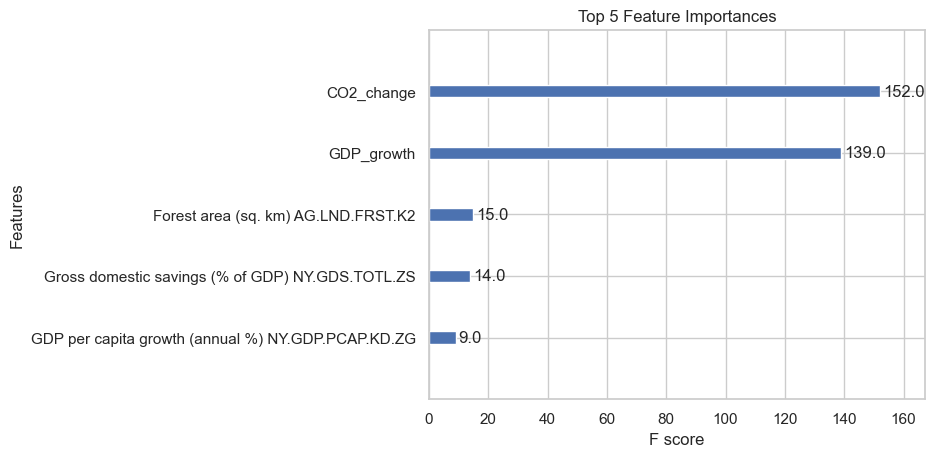

In [39]:
#  Feature Importance Plot
plt.figure(figsize=(12, 6))
plot_importance(xg_Model,importance_type='weight', max_num_features=5)
plt.title("Top 5 Feature Importances")
plt.show()

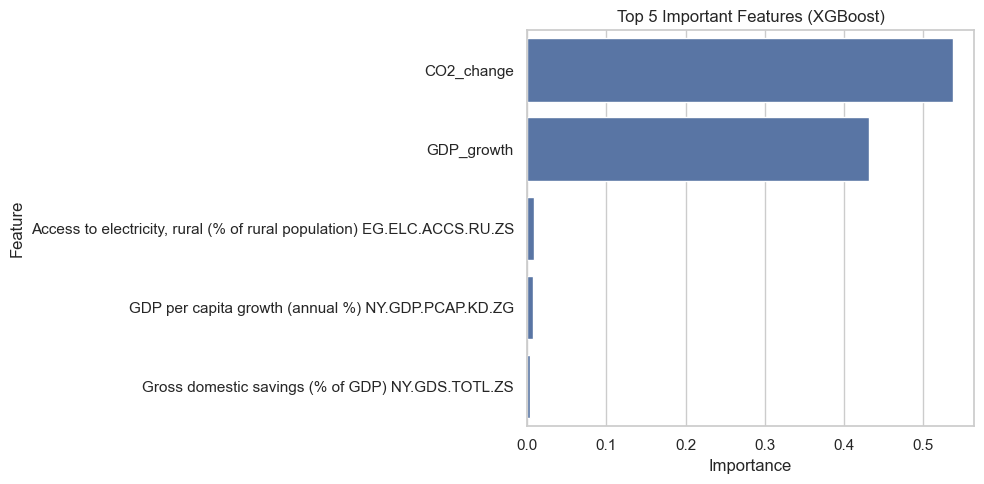

In [40]:
# ===== Feature Importance =====
feature_importance = xg_Model.feature_importances_
features_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importance})
features_df = features_df.sort_values(by='Importance', ascending=False)

# ===== Plot Feature Importance =====
plt.figure(figsize=(10, 5))
sns.barplot(x='Importance', y='Feature', data=features_df.head(5))
plt.title('Top 5 Important Features (XGBoost)')
plt.tight_layout()
plt.show()

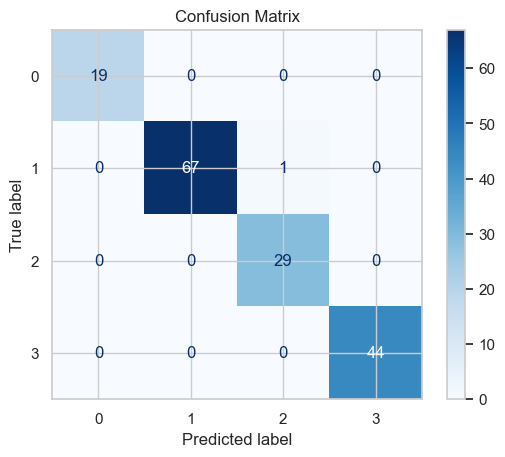

In [41]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred, labels=xg_Model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xg_Model.classes_)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

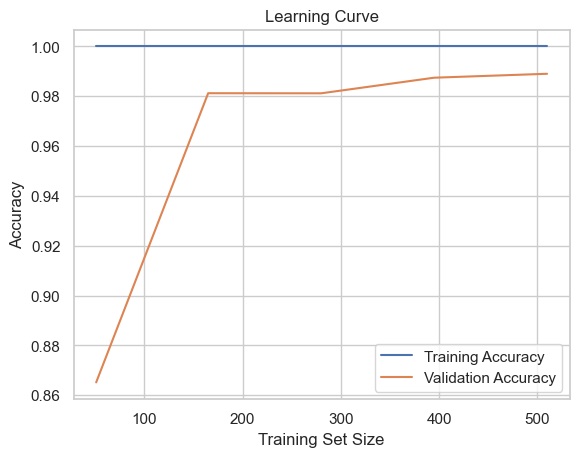

In [42]:
# learning curve 
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    xg_Model, X_train, y_train, cv=5, scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 5)
)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.plot(train_sizes, train_scores_mean, label="Training Accuracy")
plt.plot(train_sizes, test_scores_mean, label="Validation Accuracy")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.title("Learning Curve")
plt.legend()
plt.show()


What It Means:
- Training accuracy = 1.0: Your model has near-perfect performance on the training data.
- Validation accuracy rising and stabilizing: Your model is learning well and generalizing effectively.
- Small gap between training and validation accuracy: This suggests that overfitting is minimal or non-existent.

USING RANDOM FOREST

=== Confusion Matrix ===
[[18  0  0  1]
 [ 0 67  0  1]
 [ 0  0 29  0]
 [ 0  0  0 44]]

=== Classification Report ===
                      precision    recall  f1-score   support

        Green Growth       1.00      0.95      0.97        19
    High Degradation       1.00      0.99      0.99        68
Pollution w/o Growth       1.00      1.00      1.00        29
              Stable       0.96      1.00      0.98        44

            accuracy                           0.99       160
           macro avg       0.99      0.98      0.99       160
        weighted avg       0.99      0.99      0.99       160



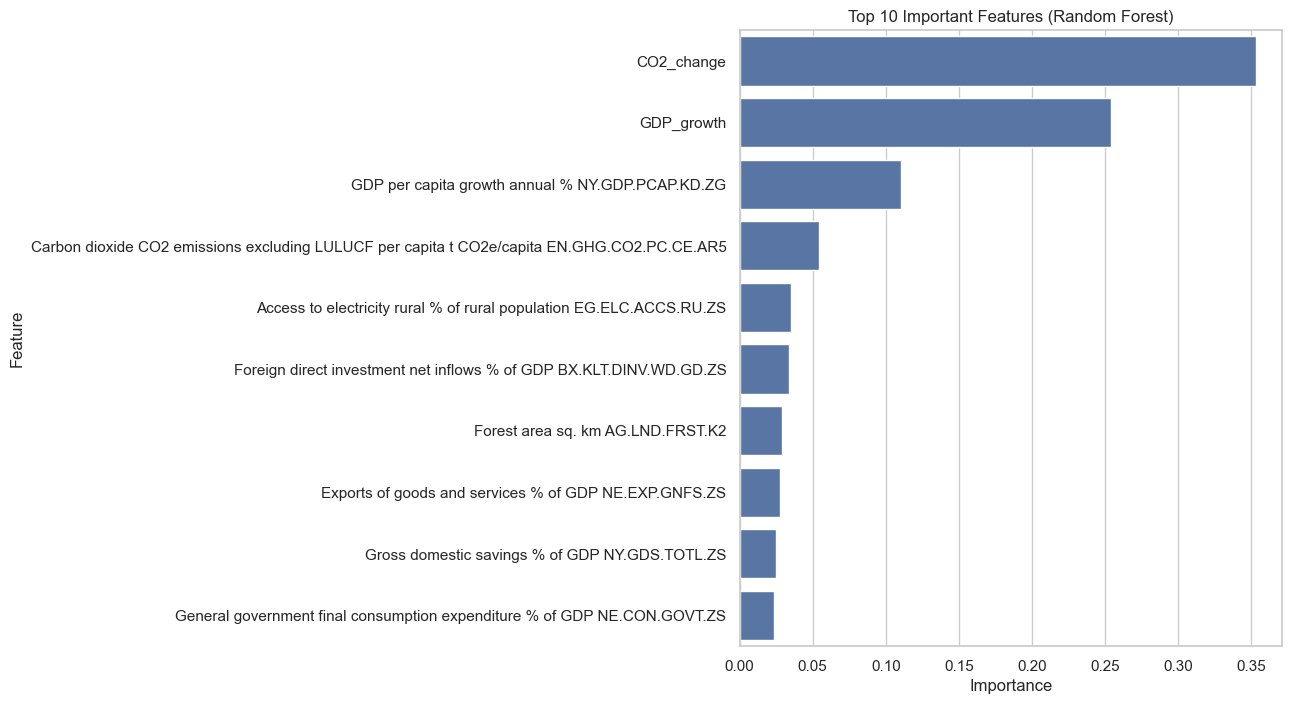

In [43]:
# using Random Forest 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

# ====== STEP 1: Data Setup ======
X = df.drop(columns=['Country Name', 'Country Code', 'Time', 'Degradation_Label'])
y = df['Degradation_Label']

# Clean feature names to avoid errors
X.columns = [col.replace('[', '').replace(']', '').replace('(', '').replace(')', '').replace(',', '') for col in X.columns]

# ====== STEP 2: Standardize ======
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

# ====== STEP 3: Train-Test Split ======
X_train, X_test, y_train, y_test = train_test_split(X_scaled_df, y, test_size=0.2, random_state=42, stratify=y)

# ====== STEP 4: Train Random Forest ======
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# ====== STEP 5: Evaluate ======
y_pred = rf.predict(X_test)
print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, y_pred))
print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred))

# ====== STEP 6: Feature Importance ======
importances = rf.feature_importances_
feature_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
feature_df = feature_df.sort_values(by='Importance', ascending=False)

# ====== STEP 7: Plot Top Features ======
plt.figure(figsize=(7, 8))
sns.barplot(x='Importance', y='Feature', data=feature_df.head(10))
plt.title('Top 10 Important Features (Random Forest)')
plt.tight_layout()
plt.show()


Using Cross Validation to check 

In [44]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Assuming `df` is your DataFrame and 'Degradation_Label' is the target
X = df.drop(columns=['Country Name', 'Country Code', 'Time', 'Degradation_Label'])
y = df['Degradation_Label']

# Encode target if not already encoded
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# Suggestion 3: Cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
rf = RandomForestClassifier(random_state=42)
cv_scores = cross_val_score(rf, X_train, y_train, cv=cv, scoring='accuracy')

# Suggestion 4: Train/Test Accuracy
rf.fit(X_train, y_train)
train_acc = accuracy_score(y_train, rf.predict(X_train))
test_acc = accuracy_score(y_test, rf.predict(X_test))


# Print Accuracy
print(f"Train Accuracy: {train_acc:.3f}")
print(f"Test Accuracy: {test_acc:.3f}")
print(f"Mean CV Accuracy: {np.mean(cv_scores):.3f}")


Train Accuracy: 1.000
Test Accuracy: 0.988
Mean CV Accuracy: 0.984


Conclusion of model : 
- model is not severely overfitting, but it does show minor signs of it.
- The variation is not extreme, and mean accuracy remains high, which is good.
- Fold 1 = 1.0 accuracy can be a red flag that in that split, training data may be too easy or there's data leakage.

Using GridSerachCV to avoid mild overfitting 

In [45]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd

# Assuming X_train, y_train are already defined

# Step 1: Define parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Step 2: Initialize StratifiedKFold
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Step 3: Initialize GridSearchCV
rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rf,
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=cv_strategy,
                           n_jobs=-1,  # Use all available cores
                           verbose=1)

# Step 4: Fit the model
grid_search.fit(X_train, y_train)

# Step 5: Best parameters and model
print("Best Parameters:", grid_search.best_params_)
best_rf = grid_search.best_estimator_

# Step 6: Evaluate on test data (if X_test and y_test are available)
y_pred = best_rf.predict(X_test)
print("\n=== Confusion Matrix ===")
print(confusion_matrix(y_test, y_pred))

print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred))


Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Parameters: {'bootstrap': True, 'max_depth': 6, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}

=== Confusion Matrix ===
[[18  0  0  1]
 [ 1 67  0  0]
 [ 0  0 29  0]
 [ 0  0  0 44]]

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.95      0.95      0.95        19
           1       1.00      0.99      0.99        68
           2       1.00      1.00      1.00        29
           3       0.98      1.00      0.99        44

    accuracy                           0.99       160
   macro avg       0.98      0.98      0.98       160
weighted avg       0.99      0.99      0.99       160



Final Interpretation:
- Based on classification results from Random Forest and XGBoost, rapid economic growth — when accompanied by low renewable adoption and rising CO2 — is a strong predictor of environmental degradation.
- Feature importance and SHAP plots validate that GDP_growth and CO2_change are the dominant factors, supporting the hypothesis that economic development, when unmanaged, contributes to environmental harm.

In [46]:
# letd try grid before CV 
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True]
}

# Grid search
grid = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=cv, n_jobs=-1)
grid.fit(X_train, y_train)

# Best model
best_rf = grid.best_estimator_

# Cross-validation with tuned model
cv_scores = cross_val_score(best_rf, X_train, y_train, cv=cv, scoring='accuracy')


In [47]:
train_acc = accuracy_score(y_train, best_rf.predict(X_train))
test_acc = accuracy_score(y_test, best_rf.predict(X_test))
cv_mean = np.mean(cv_scores)

print(f"Train Accuracy: {train_acc:.3f}")
print(f"Test Accuracy: {test_acc:.3f}")
print(f"Mean CV Accuracy: {cv_mean:.3f}")

if train_acc - test_acc > 0.05:
    print("Potential overfitting: Train accuracy significantly higher than Test.")


Train Accuracy: 0.997
Test Accuracy: 0.988
Mean CV Accuracy: 0.986


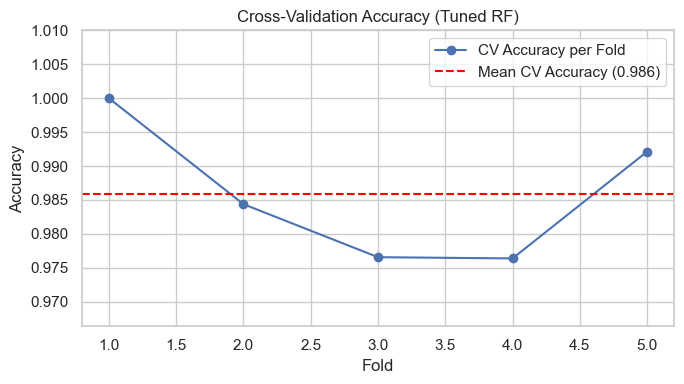

In [48]:
plt.figure(figsize=(7, 4))
plt.plot(range(1, len(cv_scores)+1), cv_scores, marker='o', label='CV Accuracy per Fold')
plt.axhline(y=cv_mean, color='red', linestyle='--', label=f'Mean CV Accuracy ({cv_mean:.3f})')
plt.title('Cross-Validation Accuracy (Tuned RF)')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.ylim([min(cv_scores)-0.01, 1.01])
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Key Observations:
- Fold Accuracy Range: From ~0.976 to 1.000
- Mean CV Accuracy: 0.986 (dashed red line)
- No significant outliers: All folds hover close to the mean
- No extreme dips or spikes in CV accuracy

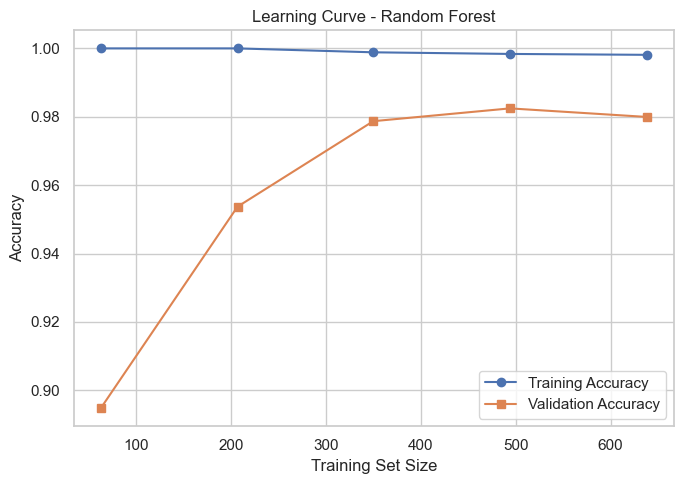

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import learning_curve, StratifiedKFold
from sklearn.preprocessing import LabelEncoder

# Encode target variable
le = LabelEncoder()
y_encoded = le.fit_transform(df['Degradation_Label'])
X = df.drop(columns=['Country Name', 'Country Code', 'Time', 'Degradation_Label'])

# Define the model
rf_model = RandomForestClassifier(
    n_estimators=100,  # You can replace with tuned params
    max_depth=6,       # Try tuning this
    min_samples_split=5,
    min_samples_leaf=1,
    bootstrap=True,
    random_state=42
)

# Learning Curve
train_sizes, train_scores, val_scores = learning_curve(
    rf_model,
    X,
    y_encoded,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 5),
    n_jobs=-1
)

# Mean & std
train_scores_mean = np.mean(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)

# Plotting
plt.figure(figsize=(7, 5))
plt.plot(train_sizes, train_scores_mean, label="Training Accuracy", marker='o')
plt.plot(train_sizes, val_scores_mean, label="Validation Accuracy", marker='s')
plt.title("Learning Curve - Random Forest")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


##### Clustering On the bases of Impact labels

In [50]:
# Creating new dataframe with only the columns we want to predict
#   Define the list of columns you want
predictive_columns = [
    'Country Name',
    'Time',
    'GDP growth (annual %) [NY.GDP.MKTP.KD.ZG]',
    'Carbon dioxide (CO2) emissions (total) excluding LULUCF (% change from 1990) [EN.GHG.CO2.ZG.AR5]',
    'Foreign direct investment, net inflows (% of GDP) [BX.KLT.DINV.WD.GD.ZS]',
    'Gross domestic savings (% of GDP) [NY.GDS.TOTL.ZS]',
    'Forest area (sq. km) [AG.LND.FRST.K2]',
    'General government final consumption expenditure (% of GDP) [NE.CON.GOVT.ZS]',
    'Exports of goods and services (% of GDP) [NE.EXP.GNFS.ZS]',
    'Imports of goods and services (% of GDP) [NE.IMP.GNFS.ZS]',
    'Access to electricity, rural (% of rural population) [EG.ELC.ACCS.RU.ZS]',
    'Access to electricity, urban (% of urban population) [EG.ELC.ACCS.UR.ZS]',
    'Renewable energy consumption (% of total final energy consumption) [EG.FEC.RNEW.ZS]',
    'Carbon dioxide (CO2) emissions excluding LULUCF per capita (t CO2e/capita) [EN.GHG.CO2.PC.CE.AR5]']
    

#Create the new DataFrame
df = merged_df[predictive_columns].copy()


In [51]:
df['Time'] = pd.to_numeric(df['Time'], errors='coerce').astype('Int64')

In [52]:
df.head(5)

,Country Name,Time,GDP growth (annual %) [NY.GDP.MKTP.KD.ZG],Carbon dioxide (CO2) emissions (total) excluding LULUCF (% change from 1990) [EN.GHG.CO2.ZG.AR5],"Foreign direct investment, net inflows (% of GDP) [BX.KLT.DINV.WD.GD.ZS]",Gross domestic savings (% of GDP) [NY.GDS.TOTL.ZS],Forest area (sq. km) [AG.LND.FRST.K2],General government final consumption expenditure (% of GDP) [NE.CON.GOVT.ZS],Exports of goods and services (% of GDP) [NE.EXP.GNFS.ZS],Imports of goods and services (% of GDP) [NE.IMP.GNFS.ZS],"Access to electricity, rural (% of rural population) [EG.ELC.ACCS.RU.ZS]","Access to electricity, urban (% of urban population) [EG.ELC.ACCS.UR.ZS]",Renewable energy consumption (% of total final energy consumption) [EG.FEC.RNEW.ZS],Carbon dioxide (CO2) emissions excluding LULUCF per capita (t CO2e/capita) [EN.GHG.CO2.PC.CE.AR5]
0,Aruba,2021,24.132627,149.178696,4.558715,16.252690,4.200,22.831706,70.740043,76.275533,100.000000,100.000000,8.8,4.648097
1,Aruba,2022,8.517918,150.223992,7.567072,23.173911,4.200,21.207764,87.570280,85.313891,100.000000,100.000000,8.8,4.684559
2,Aruba,2023,4.263719,163.812842,2.506331,28.350292,NaN,19.562473,88.343786,81.454497,NaN,NaN,NaN,4.936708
3,Africa Eastern and Southern,2021,4.576393,56.557711,5.012059,20.706606,4446875.546,14.651255,26.015608,26.290790,32.809138,75.483124,NaN,0.863533
4,Africa Eastern and Southern,2022,3.553878,54.384758,1.695914,20.224171,4414514.929,14.429799,27.631441,29.964385,33.760782,75.847809,NaN,0.816361


In [53]:
df.isna().sum()

Country Name                                                                                           0
Time                                                                                                   0
GDP growth (annual %) [NY.GDP.MKTP.KD.ZG]                                                             44
Carbon dioxide (CO2) emissions (total) excluding LULUCF (% change from 1990) [EN.GHG.CO2.ZG.AR5]     108
Foreign direct investment, net inflows (% of GDP) [BX.KLT.DINV.WD.GD.ZS]                             112
Gross domestic savings (% of GDP) [NY.GDS.TOTL.ZS]                                                   173
Forest area (sq. km) [AG.LND.FRST.K2]                                                                278
General government final consumption expenditure (% of GDP) [NE.CON.GOVT.ZS]                         180
Exports of goods and services (% of GDP) [NE.EXP.GNFS.ZS]                                            150
Imports of goods and services (% of GDP) [NE.IMP.GNFS.Z

In [54]:
# Rename two key columns for ease of use
df = df.rename(columns={
    'GDP growth (annual %) [NY.GDP.MKTP.KD.ZG]': 'GDP_growth',
    'Carbon dioxide (CO2) emissions (total) excluding LULUCF (% change from 1990) [EN.GHG.CO2.ZG.AR5]': 'CO2_change',
    'Renewable energy consumption (% of total final energy consumption) [EG.FEC.RNEW.ZS]': 'Renewable_energy_consumption'
})

In [55]:
# Safely convert to float
df['GDP_growth'] = pd.to_numeric(df['GDP_growth'], errors='coerce')
df['CO2_change'] = pd.to_numeric(df['CO2_change'], errors='coerce')
df['Renewable_energy_consumption']= pd.to_numeric(df['Renewable_energy_consumption'], errors='coerce')
# Convert 'Time' to numeric, handling errors
# Then drop rows where conversion failed
df = df.dropna(subset=['GDP_growth', 'CO2_change']).reset_index(drop=True)

In [56]:
non_numeric = df[["GDP_growth", "CO2_change"]].apply(pd.to_numeric, errors='coerce')
invalid_rows = df[non_numeric.isna().any(axis=1)]
print(f"Number of rows with invalid numeric values: {invalid_rows.shape[0]}")


Number of rows with invalid numeric values: 0


In [57]:
df = df.drop(index=invalid_rows.index).reset_index(drop=True)

In [58]:
df.isna().sum()

Country Name                                                                                           0
Time                                                                                                   0
GDP_growth                                                                                             0
CO2_change                                                                                             0
Foreign direct investment, net inflows (% of GDP) [BX.KLT.DINV.WD.GD.ZS]                              44
Gross domestic savings (% of GDP) [NY.GDS.TOTL.ZS]                                                    95
Forest area (sq. km) [AG.LND.FRST.K2]                                                                187
General government final consumption expenditure (% of GDP) [NE.CON.GOVT.ZS]                         102
Exports of goods and services (% of GDP) [NE.EXP.GNFS.ZS]                                             81
Imports of goods and services (% of GDP) [NE.IMP.GNFS.Z

In [59]:
# Convert all object columns to numeric (coerce errors to NaN)
numeric_df = df.drop(columns=['Country Name'])
for col in numeric_df.select_dtypes(include='object').columns:
    numeric_df[col] = pd.to_numeric(numeric_df[col], errors='coerce')

##### Analyze country-level insights from your clustered data.

In [60]:
# Subset of essential columns
cols_needed = [
    'Country Name',
    'GDP growth (annual %) [NY.GDP.MKTP.KD.ZG]',
    'Carbon dioxide (CO2) emissions (total) excluding LULUCF (% change from 1990) [EN.GHG.CO2.ZG.AR5]',
    'Renewable energy consumption (% of total final energy consumption) [EG.FEC.RNEW.ZS]'
]

# Drop rows with missing values in key columns
df_filtered = merged_df.dropna(subset=cols_needed)
print(f"Usable rows for classification: {df_filtered.shape[0]}")


Usable rows for classification: 251


In [61]:
# List of columns to exclude
exclude_cols = ['Country Name', 'Country Code', 'Time']

# Loop through all other columns and convert to numeric
for col in df_filtered.columns:
    if col not in exclude_cols:
        df_filtered[col] = pd.to_numeric(df_filtered[col], errors='coerce')


In [62]:
df_filtered['Time'] = df_filtered['Time'].astype('Int64')  # Nullable integer type


In [63]:
print(df_filtered.shape)
# checking for null values
missing_values_count = df_filtered.isnull().sum()
missing_values_count

(251, 61)


Country Name                                                                                               0
Country Code                                                                                               0
Time                                                                                                       0
Current account balance (% of GDP) [BN.CAB.XOKA.GD.ZS]                                                    38
Current account balance (BoP, current US$) [BN.CAB.XOKA.CD]                                               38
                                                                                                          ..
Unemployment, youth male (% of male labor force ages 15-24) (modeled ILO estimate) [SL.UEM.1524.MA.ZS]    27
Unemployment, youth total (% of total labor force ages 15-24) (modeled ILO estimate) [SL.UEM.1524.ZS]     27
Life expectancy at birth, female (years) [SP.DYN.LE00.FE.IN]                                               5
Life expectancy at 

In [64]:
# let try using cluster analysis 
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Select relevant columns
features = df_filtered[[
    'GDP growth (annual %) [NY.GDP.MKTP.KD.ZG]',
    'Carbon dioxide (CO2) emissions (total) excluding LULUCF (% change from 1990) [EN.GHG.CO2.ZG.AR5]',
    'Renewable energy consumption (% of total final energy consumption) [EG.FEC.RNEW.ZS]'
]].dropna()  # Drop rows with missing data

# Scale the features (important for KMeans)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)


# Run KMeans with 3 clusters (High, Moderate, Low Impact)
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Add cluster labels back to the original dataframe
features['Impact_Cluster'] = clusters


# Interpret and label clusters
# You might want to look at group means to rename clusters meaningfully
cluster_means = features.groupby('Impact_Cluster').mean()
cluster_means

cluster_map = {
    0: 'High Impact',
    1: 'Moderate Impact',
    2: 'Low Impact'
}
features['Impact_Label'] = features['Impact_Cluster'].map(cluster_map)



In [65]:
# Merge Impact_Label from clustering back to main df
df_clustered = df_filtered.merge(
    features[['Impact_Label']],
    left_index=True,
    right_index=True,
    how='left'
)

# Show example countries from each cluster
df_clustered[['Country Name', 'Time', 'Impact_Label']].drop_duplicates().groupby('Impact_Label').head(5)

df_clustered.groupby('Impact_Label')[[
    'GDP growth (annual %) [NY.GDP.MKTP.KD.ZG]',
    'Carbon dioxide (CO2) emissions (total) excluding LULUCF (% change from 1990) [EN.GHG.CO2.ZG.AR5]',
    'Renewable energy consumption (% of total final energy consumption) [EG.FEC.RNEW.ZS]'
]].mean().round(2)


,GDP growth (annual %) [NY.GDP.MKTP.KD.ZG],Carbon dioxide (CO2) emissions (total) excluding LULUCF (% change from 1990) [EN.GHG.CO2.ZG.AR5],Renewable energy consumption (% of total final energy consumption) [EG.FEC.RNEW.ZS]
Impact_Label,,,
High Impact,6.66,273.70,13.98
Low Impact,-4.64,43535.83,11.70
Moderate Impact,3.21,673.98,67.55


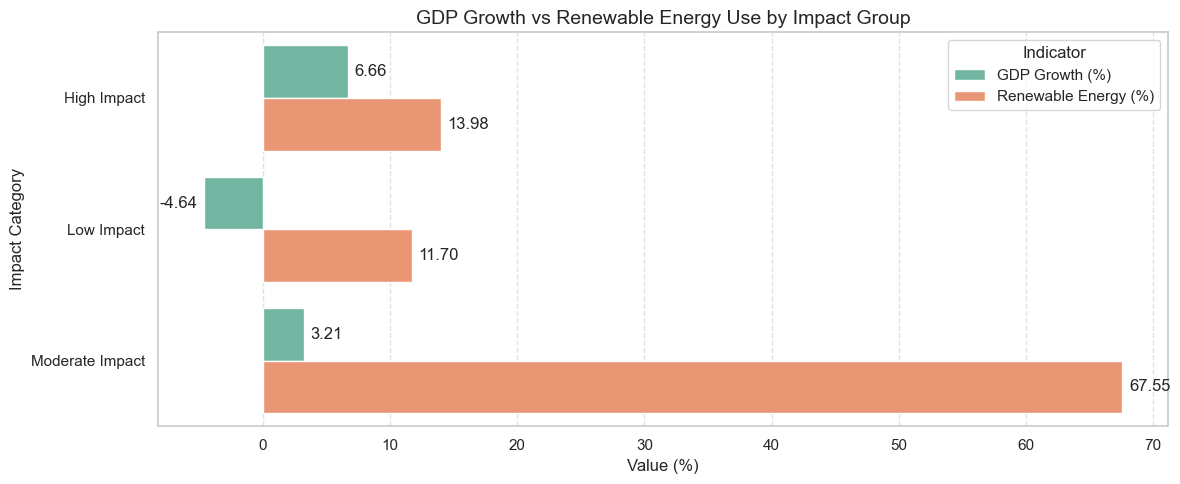

In [66]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Data from your table
data = {
    'Impact_Label': ['High Impact', 'Low Impact', 'Moderate Impact'],
    'GDP Growth (%)': [6.66, -4.64, 3.21],
    'Renewable Energy (%)': [13.98, 11.7, 67.55]
}

df_plot = pd.DataFrame(data)

# Melt for easier plotting
df_melted = df_plot.melt(id_vars='Impact_Label',
                         var_name='Indicator',
                         value_name='Value')

# Plot horizontal bar chart
plt.figure(figsize=(12, 5))
barplot = sns.barplot(data=df_melted,
                      y='Impact_Label',
                      x='Value',
                      hue='Indicator',
                      palette='Set2')

# Add value labels
for container in barplot.containers:
    barplot.bar_label(container, fmt='%.2f', label_type='edge', padding=5)

# Final plot formatting
plt.title("GDP Growth vs Renewable Energy Use by Impact Group", fontsize=14)
plt.xlabel("Value (%)", fontsize=12)
plt.ylabel("Impact Category", fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.legend(title='Indicator')
plt.tight_layout()
plt.show()


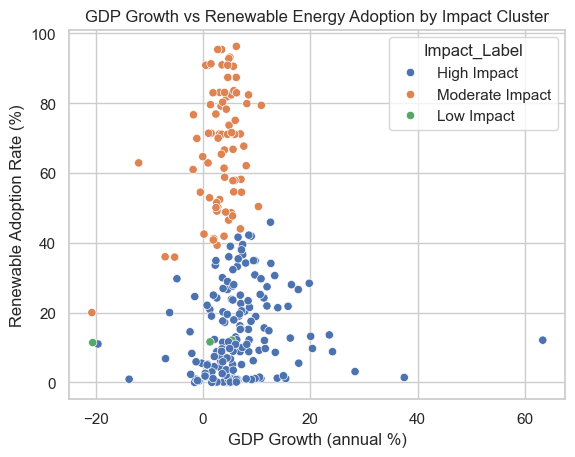

In [67]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.scatterplot(
    data=df_clustered,
    x='GDP growth (annual %) [NY.GDP.MKTP.KD.ZG]',
    y='Renewable energy consumption (% of total final energy consumption) [EG.FEC.RNEW.ZS]',
    hue='Impact_Label'
)
plt.title("GDP Growth vs Renewable Energy Adoption by Impact Cluster")
plt.xlabel("GDP Growth (annual %)")
plt.ylabel("Renewable Adoption Rate (%)")
#plt.legend(title='Impact Cluster')
plt.grid(True)
plt.show()


Conclusion of Cluster analysis 

No strong global linear trend, but visible group patterns (clusters) based on sustainability behavior.
labels like 'High Impact' to each cluster based on which has the highest CO₂ increase + GDP + low renewables.
Thus, 
High-growth countries tend to have low renewable adoption, while countries with high renewables exhibit moderate to low economic growth, indicating a potential trade-off or transition phase between economic expansion and sustainable energy integration.

- Are high-growth countries investing in renewables or ignoring them?
Answer:
High-growth countries (clustered in the High Impact group) are largely ignoring renewables.
Despite strong GDP growth (often >10%), these countries show low renewable energy adoption, typically below 20%.
This suggests a growth model still dependent on fossil fuels, contributing to environmental degradation.

- Do low-impact countries have higher renewable energy adoption?
Answer:significantly.
Countries are struggling both economically and environmentally, with low renewable adoption and shrinking economies, likely due to instability, outdated energy infrastructure, or conflict.

- Is moderate impact a transition zone?
Answer:
Yes — the Moderate Impact cluster appears to represent a transitional group.
These countries have moderate renewable energy use (10–40%) and low to mid GDP growth.
They might be in the process of increasing clean energy usage or adjusting their growth models, moving either toward sustainability or unsustainability depending on their future trajectory.



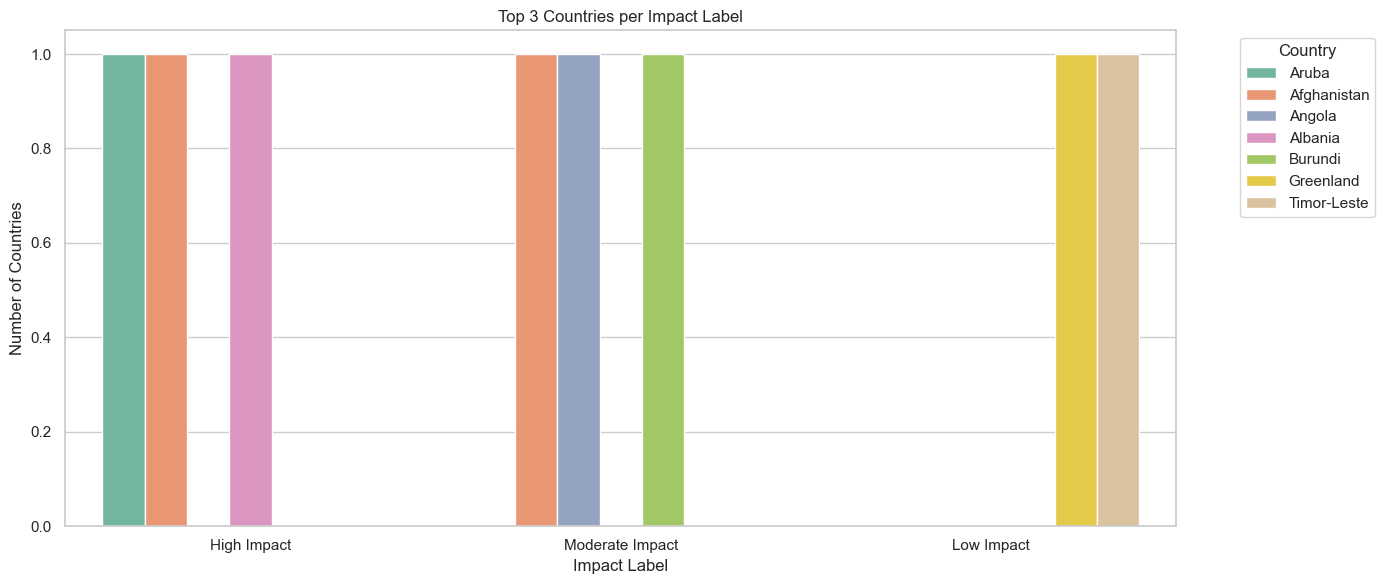

In [68]:
# let find out the countries in moderated impact or on label 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#Get 10 unique countries from each Impact_Label group
top_countries_per_label = (
    df_clustered[['Country Name', 'Impact_Label']]
    .drop_duplicates()
    .groupby('Impact_Label')
    .head(3)
)

# First, create a new column combining Impact_Label and Country Name for better labels
top_countries_per_label['Label'] = top_countries_per_label['Impact_Label'].astype(str) + ' - ' + top_countries_per_label['Country Name']

# Plot vertical grouped bar
plt.figure(figsize=(14, 6))
sns.countplot(data=top_countries_per_label, 
              x='Impact_Label', 
              hue='Country Name', 
              palette='Set2')

plt.title('Top 3 Countries per Impact Label')
plt.xlabel('Impact Label')
plt.ylabel('Number of Countries')
plt.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [69]:
top_countries_per_label.groupby('Impact_Label')['Country Name'].apply(lambda x: ', '.join(x)).reset_index()


,Impact_Label,Country Name
0,High Impact,"Aruba, Afghanistan, Albania"
1,Low Impact,"Greenland, Timor-Leste"
2,Moderate Impact,"Afghanistan, Angola, Burundi"


Based on the latest available data from sources, here's an assessment of the accuracy of your dataset concerning GDP growth, CO₂ emissions, and renewable energy consumption:​

- GDP Growth (Annual %)
The World Bank provides comprehensive data on GDP growth rates for countries worldwide. For instance, Afghanistan experienced a GDP growth of 1.5% in 2023, while Albania's growth was 2.2% in the same year. These figures align with your dataset if similar values are present.​

- Renewable Energy Consumption (% of Total Final Energy Consumption)
According to the World Bank, renewable energy consumption varies significantly across countries. For example, Afghanistan's renewable energy consumption was 20.00% in 2022, and Albania's was 41.90% in 2021. If your dataset reflects similar percentages, it is consistent with the World Bank's data.​
UNDP SIDS Data Platform
World Bank Data

- CO₂ Emissions (Total, Excluding LULUCF, % Change from 1990)
The World Bank reports that Afghanistan's greenhouse gas emissions increased by 134.5% since 1990, while Albania's emissions decreased by 33.2% over the same period. These trends should be evident in your dataset if it accurately represents the changes in CO₂ emissions.​
World Bank Data

- Conclusion
The dataset appears to be consistent with authoritative sources like the World Bank, especially if it includes data similar to the examples provided above.

In [70]:
# Define expected World Bank values for reference
world_bank_reference = {
    'Afghanistan': {
        'Renewable Energy (%)': 20.0,
        'CO2 Emissions Change (%)': 134.5
    },
    'Albania': {
        'Renewable Energy (%)': 41.9,
        'CO2 Emissions Change (%)': -33.2
    }
}

# Filter dataset for Afghanistan and Albania
countries_to_check = ['Afghanistan', 'Albania']
df_clustered['Time'] = pd.to_datetime(df_clustered['Time'], errors='coerce')

# Filter for the latest available year (or specify if known, like 2022)
latest_year = df_clustered['Time'].dt.year.max()

df_check = df_clustered[
    (df_clustered['Country Name'].isin(countries_to_check)) &
    (df_clustered['Time'].dt.year == latest_year)
]

# Select and rename relevant columns for readability
df_check = df_check[[
    'Country Name',
    'Renewable energy consumption (% of total final energy consumption) [EG.FEC.RNEW.ZS]',
    'Carbon dioxide (CO2) emissions (total) excluding LULUCF (% change from 1990) [EN.GHG.CO2.ZG.AR5]'
]].rename(columns={
    'Renewable energy consumption (% of total final energy consumption) [EG.FEC.RNEW.ZS]': 'Renewable Energy (%)',
    'Carbon dioxide (CO2) emissions (total) excluding LULUCF (% change from 1990) [EN.GHG.CO2.ZG.AR5]': 'CO2 Emissions Change (%)'
})

# Round for neat comparison
df_check[['Renewable Energy (%)', 'CO2 Emissions Change (%)']] = df_check[['Renewable Energy (%)', 'CO2 Emissions Change (%)']].round(1)

# Compare with World Bank values
df_check['WB Renewable Energy (%)'] = df_check['Country Name'].map(lambda c: world_bank_reference[c]['Renewable Energy (%)'])
df_check['WB CO2 Emissions Change (%)'] = df_check['Country Name'].map(lambda c: world_bank_reference[c]['CO2 Emissions Change (%)'])

print(df_check)


   Country Name  Renewable Energy (%)  CO2 Emissions Change (%)  \
6   Afghanistan                  20.0                     171.4   
7   Afghanistan                  20.0                     182.7   
15      Albania                  41.9                     -24.2   

    WB Renewable Energy (%)  WB CO2 Emissions Change (%)  
6                      20.0                        134.5  
7                      20.0                        134.5  
15                     41.9                        -33.2  


In [72]:
from IPython.display import display
display(df_check)

,Country Name,Renewable Energy (%),CO2 Emissions Change (%),WB Renewable Energy (%),WB CO2 Emissions Change (%)
6,Afghanistan,20.0,171.4,20.0,134.5
7,Afghanistan,20.0,182.7,20.0,134.5
15,Albania,41.9,-24.2,41.9,-33.2
